<a href="https://colab.research.google.com/github/rooncal/Image-Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal_ as he_initialization
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import cv2
import random
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image
 
 
from functools import reduce
import numpy as np
import os
import sys
from google.colab import drive
from glob import glob
import matplotlib.pyplot as plt
 
#!pip install elasticdeform
!pip install albumentations
import albumentations as A
import elasticdeform

In [2]:
%matplotlib inline

##Preparing the data

In [3]:
!git clone https://github.com/zhixuhao/unet.git
!mv unet/data/membrane/train .
!mv unet/data/membrane/test .
!rm -rf unet
!rm -rf train/aug

Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (80/80), done.
mv: cannot move 'unet/data/membrane/train' to './train': Directory not empty
mv: cannot move 'unet/data/membrane/test' to './test': Directory not empty


##Loading the data

In [4]:
import torch.utils.data as data
 
class DataSetSegmentation(data.Dataset):
    def __init__(self, folder_path, transform=None):
        super(DataSetSegmentation, self).__init__()
        self.img_files = glob(os.path.join(folder_path,'image/','*.png'))
        self.mask_files = glob(os.path.join(folder_path,'label/','*.png'))
        self.transform = transform
 
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = Image.open(img_path)
            label = Image.open(mask_path)
            if self.transform:
              transformed_data, transformed_label = self.transform(data,label)
              return transformed_data, transformed_label
            return data, label
 
    def __len__(self):
        return len(self.img_files)

In [45]:
class ElasticTransform(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, sigma=10, alpha=120, alpha_affine=120):
      self.sigma = sigma
      self.alpha = alpha
      self.alpha_affine = alpha_affine
 
 
    def __call__(self, image, mask):
      image, mask = np.asarray(image), np.asarray(mask)
      shape = image.shape
      aug = A.ElasticTransform(p=1, alpha=self.alpha, sigma=self.sigma * 0.05, alpha_affine=self.alpha_affine * 0.03)
      [image_elastic, mask_elastic] = aug(image=image, mask=mask)
      return Image.fromarray(image), Image.fromarray(mask)

In [6]:
class Resize(object):
  def __init__(self, size=(520,520)):
    self.size = size

  def __call__(self, img, mask):
    resize = T.Resize(size=self.size)
    return resize(img), resize(mask)

In [7]:
class RandomCrop(object):
  def __init__(self, output_size=(512,512)):
    self.output_size = output_size

  def __call__(self, img, mask):
    i, j, h, w = T.RandomCrop.get_params(
            img, output_size=self.output_size)
    img = F.crop(img, i, j, h, w)
    mask = F.crop(mask, i, j, h, w)
    return img, mask


In [8]:
class RandomHorizontalFlip(object):
  def __call__(self, img, mask):
    if random.random() > 0.5:
      img = F.hflip(img)
      mask = F.hflip(mask)
    return img, mask


In [9]:
class RandomVerticalFlip(object):
  def __call__(self, img, mask):
    if random.random() > 0.5:
      img = F.vflip(img)
      mask = F.vflip(mask)
    return img, mask


In [10]:
class ToTensor(object):
  def __call__(self, img, mask):
    return F.to_tensor(img), F.to_tensor(mask)

In [11]:
class Compose(T.Compose):
 
    def __call__(self, img, mask):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask

In [46]:
transform = Compose([
                ElasticTransform(), Resize(), RandomCrop(), RandomHorizontalFlip(), RandomVerticalFlip(), ToTensor()
            ]) 

loader_train = DataSetSegmentation(folder_path='/content/train', transform=transform)
data_loader_train = DataLoader(loader_train,1,sampler=sampler.SubsetRandomSampler(range(25)))
data_loader_val = DataLoader(loader_train,1,sampler=sampler.SubsetRandomSampler(range(25,30)))

In [47]:
loader_train[0]

(tensor([[[0.7333, 0.7059, 0.7569,  ..., 0.7490, 0.6000, 0.4941],
          [0.7216, 0.6510, 0.7176,  ..., 0.6941, 0.6980, 0.5804],
          [0.6706, 0.6627, 0.6863,  ..., 0.6196, 0.7412, 0.6275],
          ...,
          [0.7490, 0.8157, 0.9333,  ..., 0.6863, 0.6314, 0.5882],
          [0.7216, 0.7255, 0.8980,  ..., 0.5529, 0.4196, 0.4078],
          [0.7569, 0.6980, 0.7529,  ..., 0.5608, 0.4549, 0.3804]]]),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]))

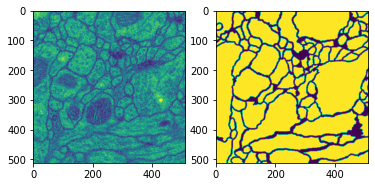

In [48]:
fig=plt.figure()
fig.add_subplot(1,2,1)
x,y = loader_train[0]
plt.imshow(x[0])
fig.add_subplot(1,2,2)
plt.imshow(y[0])
plt.show()

##Building the model

In [15]:
class TwoConvsDown(nn.Module):
  def __init__(self,in_channels):
    super().__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels, in_channels*2, 3, padding=1)
    he_initialization(self.conv1.weight)
    self.conv2 = nn.Conv2d(in_channels*2, in_channels*2, 3, padding=1)
    he_initialization(self.conv2.weight)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x
 
 
class TwoConvsUp(nn.Module):
  def __init__(self,in_channels):
    super().__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels, in_channels//2, 3, padding=1)
    he_initialization(self.conv1.weight)
    self.conv2 = nn.Conv2d(in_channels//2, in_channels//2, 3, padding=1)
    he_initialization(self.conv2.weight)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

In [24]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1, 64, 3,padding=1)
    he_initialization(self.conv1.weight)
    self.conv2 = nn.Conv2d(64, 64, 3,padding=1)
    he_initialization(self.conv2.weight)
    self.twoconv1 = TwoConvsDown(64)
    self.twoconv2 = TwoConvsDown(128)
    self.twoconv3 = TwoConvsDown(256)
    self.twoconv4 = TwoConvsDown(512)
    self.twoconv5 = TwoConvsUp(1024)
    self.twoconv6 = TwoConvsUp(512)
    self.twoconv7 = TwoConvsUp(256)
    self.twoconv8 = TwoConvsUp(128)
    self.finalconv = nn.Conv2d(64,2,1)
    he_initialization(self.finalconv.weight)
 
    self.oneconv1 = nn.Conv2d(1024,512,2,1,dilation=2,padding=1)
    he_initialization(self.oneconv1.weight)
    self.oneconv2 = nn.Conv2d(512,256,2,1,dilation=2,padding=1)
    he_initialization(self.oneconv2.weight)
    self.oneconv3 = nn.Conv2d(256,128,2,1,dilation=2,padding=1)
    he_initialization(self.oneconv3.weight)
    self.oneconv4 = nn.Conv2d(128,64,2,1,dilation=2,padding=1)
    he_initialization(self.oneconv4.weight)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    concat_1 = x
    x = nn.MaxPool2d(2)(x)
 
    x =self.twoconv1(x)
    concat_2 = x
    x = nn.MaxPool2d(2)(x)
 
    x = self.twoconv2(x)
    concat_3 = x
    x = nn.MaxPool2d(2)(x)
    x = self.twoconv3(x)
    
    concat_4 = x
    x = nn.MaxPool2d(2)(x)
    x = self.twoconv4(x)
    x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x)
    x = self.oneconv1(x)
    
    x = torch.cat((concat_4, x), 1)
    x = self.twoconv5(x)
 
    x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x)
    x = self.oneconv2(x)
    x = torch.cat((concat_3, x), 1)
    x = self.twoconv6(x)
 
    x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x)
    x = self.oneconv3(x)
    x = torch.cat((concat_2, x), 1)
    x = self.twoconv7(x)
 
    x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x)
    x = self.oneconv4(x)
    x = torch.cat((concat_1, x), 1)
    x = self.twoconv8(x)
 
    x = self.finalconv(x)
    
    return x

In [25]:
x = torch.zeros((1, 1, 512, 512), dtype=torch.float32)
model = Unet()
scores = model(x)
print(scores.size())

torch.Size([1, 2, 512, 512])


In [49]:
model = Unet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda(device)

Unet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (twoconv1): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (twoconv2): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (twoconv3): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (twoconv4): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), strid

In [51]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    model.eval()
    with torch.no_grad():
      intersection, union = 0.0, 0.0
      for class_prediction in outputs[0]:
        intersection += torch.logical_and(labels, class_prediction)
        union += torch.logical_or(labels, outputs)
      iou_score = torch.sum(intersection) / torch.sum(union)
      return iou_score 

In [52]:
def check_accuracy(loader, model):  
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        running_loss = 0.0
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = loss_function(scores, y.squeeze(1))
            running_loss += loss.item()
            if i % 5 == 4:    # print every 5 mini-batches
              return running_loss / 5

In [53]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.99)
 
for epoch in range(20):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(data_loader_train, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
 
        # zero the parameter gradients
        optimizer.zero_grad()
 
        inputs, labels = inputs.to(device), labels.to(device)
 
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels.long().squeeze(1))
        loss.backward()
        optimizer.step()
 
        # print statistics
        running_loss += loss.item()
        if i % 25 == 24:    # print every 2000 mini-batches
            validation_loss = check_accuracy(data_loader_val, model)
            iou = iou_pytorch(outputs, labels).item()
            print(f'Epoch: {epoch + 1} training loss: {running_loss / 30:.3f} validation loss: {validation_loss:.3f} mean IoU: {iou:.3f}')
            running_loss = 0.0
 
print('Finished Training')

Epoch: 2 training loss: 0.458 validation loss: 0.523 mean IoU: 0.412


KeyboardInterrupt: ignored

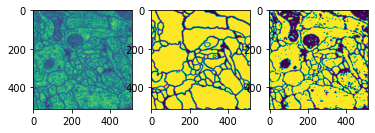

In [44]:
dataiter = iter(data_loader_train)
images, labels = dataiter.next()
output = model(images.to(device))
fig=plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(images[0][0])
fig.add_subplot(1,3,2)
plt.imshow(labels[0][0])
fig.add_subplot(1,3,3)
plt.imshow((output[0][1].cpu().data.numpy()>output[0][0].cpu().data.numpy()).astype(int))